In [1]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
iris = datasets.load_iris()
X = iris.data
Y = iris.target
X.shape,Y.shape

((150, 4), (150,))

### Y_train one-hot编码

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=True)
X_train = X_train.transpose()
X_test = X_test.transpose()
Y_train_one_hot = np.zeros((3, len(Y_train)))
for i in range(len(Y_train)):
    Y_train_one_hot[Y_train[i], i] = 1
Y_test = Y_test.transpose()
print(X_train.shape, X_test.shape, Y_train.shape,Y_train_one_hot.shape, Y_test.shape)

(4, 105) (4, 45) (105,) (3, 105) (45,)


In [4]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

### 数值安全 $$ a = \sigma(z) = \frac{\exp(z_i-c)}{\sum_j\exp(z_j - c)} $$

$$ c = \max_iz_i $$

In [5]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    # Inputs: "A_prev, W, b". Outputs: "A, activation_cache". 
    if activation == 'relu':
        Z = np.dot(W, A_prev) + b
        A = np.maximum(0, Z)
    
    elif activation == 'softmax':
        Z = np.dot(W, A_prev) + b
        C = np.max(Z, axis = 0)
        A = np.exp(Z - C) / np.sum(np.exp(Z - C), axis = 0, keepdims=True) #数值稳定
    cache = (A_prev, W, b, Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    
    return A, cache

In [6]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W'+str(l)], parameters['b'+str(l)], 'relu')
        caches.append(cache)
    
    # Implement LINEAR -> softmax. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W'+str(L)], parameters['b'+str(L)], 'softmax')  
    caches.append(cache)
    
    assert(AL.shape == (3,X.shape[1]))
            
    return AL, caches

### 损失函数使用交叉熵损失函数：
$$ L = - \frac{1}{m}\sum_i\sum_ky^i_k\log a^i_k $$

In [7]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = - np.sum(np.log(np.sum(AL*Y, axis=0))) / m
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

The three outputs $(dW^{[l]}, db^{[l]}, dA^{[l]})$ 
$dZ^{[l]}$.Here are the formulas you need:
$$ dW^{[l]} = \frac{\partial \mathcal{L} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} $$
$$ db^{[l]} = \frac{\partial \mathcal{L} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} $$

In [8]:
def linear_backward(dZ, A_prev, W, b):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    m = A_prev.shape[1]

    dW = np.dot(dZ, A_prev.transpose()) / m
    db = np.sum(dZ, axis = 1, keepdims=True) / m
    dA_prev = np.dot(W.transpose(), dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

If $g(.)$ is the activation function, 
`relu_backward` compute $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]})$$

In [9]:
def linear_activation_backward(dA, cache, activation='relu'):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b, Z = cache
    
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    dA_prev, dW, db = linear_backward(dZ, A_prev, W, b)
        
    return dA_prev, dW, db

### softmax梯度
 $ a_i = \frac{e^{z_i}}{\sum_je^{z_j}} $   $$ L = - \sum_ky_k\log{a_k} $$  
  当 $i = j$ 时 
$$ \frac{da_i}{dz_j} = \frac{e^{a_i\sum_kle^{z_k} - e^{z_i}e^{z_i}}}{(\sum_ke^{z_k})^2} = a_i(1 - a_i)$$ 
  当 $ i\neq j $ 时
 $$ \frac{da_i}{dz_j} = - \frac{e^{a_i}e^{a_j}}{(\sum_ke^{z_k})^2} = -a_ia_j $$
 
$$ \frac{d_L}{dz_i} = - \sum_ky_k\frac{1}{a_k}\frac{da_k}{dz_i} = -\frac{y_i}{a_i}a_i(1-a_i) + \sum_{k\neq i}\frac{y_k}{a_k}a_ia_k = -y_i + y_ia_i + \sum_{k\neq i}y_ka_i $$ $$= -y_i + a_i\sum_ky_k = a_i - y_i$$


In [10]:
def softmax_backward(dAL, AL):
    n = AL.shape[0]
    dA_dZ = np.zeros((n, n))
    dZ = np.zeros(AL.shape)
    for l in range(AL.shape[1]):
        for i in range(n):
            for j in range(n):
                if i == j:
                    dA_dZ[i, j] = AL[i, l]*(1 - AL[i, l])
                else: 
                    dA_dZ[i, j] = - AL[i, l]*AL[j, l]
#         print(dA_dZ)
        dZ[:,l] = np.dot(dA_dZ, dAL[:, l])
    return dZ
        

In [11]:
Y = np.array([[1], [0], [0]])
AL = np.array([[0.3], [0.2], [0.5]])
dAL = - Y/ AL
print(dAL)
dZ = softmax_backward(dAL, AL)
print(dZ)
print(AL - Y)
print(dZ == AL - Y)

[[-3.33333333]
 [ 0.        ]
 [ 0.        ]]
[[-0.7]
 [ 0.2]
 [ 0.5]]
[[-0.7]
 [ 0.2]
 [ 0.5]]
[[ True]
 [ True]
 [ True]]


In [12]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sofymax" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
#     dZl = AL - Y
    dAL = - Y / AL
    dZL = softmax_backward(dAL, AL)
    assert(dZL.shape == (AL - Y).shape)
            
    # Lth layer (SOFTMAX -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    A_prev, W, b, Z = caches[L - 1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_backward(dZL, A_prev, W, b)
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, activation='relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [13]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] -= learning_rate*grads['dW' + str(l+1)]
        parameters["b" + str(l+1)] -= learning_rate*grads['db' + str(l+1)]
        
    return parameters

In [14]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 300, print_cost=True):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    parameters = initialize_parameters_deep(layers_dims)
   
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches =  L_model_forward(X, parameters)
       
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 20 == 0:
            costs.append(cost)
            print ("Cost after iteration %i: %f" %(i, cost))
            
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 7.348496
Cost after iteration 20: 0.926522
Cost after iteration 40: 0.812820
Cost after iteration 60: 0.731598
Cost after iteration 80: 0.666303
Cost after iteration 100: 0.609205
Cost after iteration 120: 0.558459
Cost after iteration 140: 0.512316
Cost after iteration 160: 0.470838
Cost after iteration 180: 0.433557
Cost after iteration 200: 0.400496
Cost after iteration 220: 0.371463
Cost after iteration 240: 0.346202
Cost after iteration 260: 0.324316
Cost after iteration 280: 0.305439


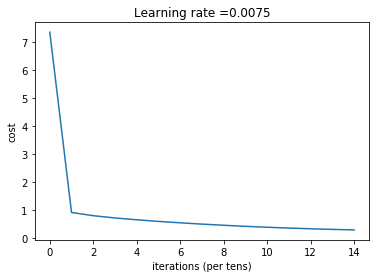

In [15]:
layers_dims = [4, 6, 3] 
parameters = L_layer_model(X_train, Y_train_one_hot, layers_dims)

In [16]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    # convert probas to 0/1 predictions
    p = probas.argmax(0) 
#     for i in range(0, probas.shape[1]):
#            p[0,i] = 
    
    print ("predictions: " + str(p))
    print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [17]:
predict(X_test, Y_test, parameters)

predictions: [2 0 2 1 1 0 2 2 1 1 0 1 1 0 0 1 2 0 2 1 0 0 1 1 1 2 0 2 2 2 0 2 1 0 2 1 2
 0 0 2 0 2 0 1 0]
true labels: [2 0 2 1 1 0 2 2 2 1 0 2 1 0 0 1 2 0 2 1 0 0 1 1 1 2 0 2 2 2 0 2 1 0 2 1 2
 0 0 2 0 2 0 1 0]
Accuracy: 0.955555555556


array([2, 0, 2, 1, 1, 0, 2, 2, 1, 1, 0, 1, 1, 0, 0, 1, 2, 0, 2, 1, 0, 0, 1,
       1, 1, 2, 0, 2, 2, 2, 0, 2, 1, 0, 2, 1, 2, 0, 0, 2, 0, 2, 0, 1, 0], dtype=int64)